In [1]:
import os 
import re 
import warnings
from datetime import datetime as time

from typing import Iterable
from collections import Counter
from multiprocessing import Pool

import artm
import pandas as pd

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from preprocessing_tools import lemmatization

In [3]:
data = pd.read_csv('Russia.csv')

In [4]:
data.head()

1914-lenta/                                               url  \
0  1999-10-01 12:00:00            https://lenta.ru/news/1999/10/01/army/   
1  1999-10-01 12:00:00       https://lenta.ru/news/1999/10/01/bezhentsy/   
2  1999-10-01 12:00:00  https://lenta.ru/news/1999/10/01/chechnya_vlast/   
3  1999-10-01 12:00:00    https://lenta.ru/news/1999/10/01/chechnya_war/   
4  1999-10-01 12:00:00         https://lenta.ru/news/1999/10/01/hotline/   

   edition  topics                                              title  \
0      NaN  Россия                         Начался осенний призыв '99   
1      NaN  Россия       Число беженцев в Ингушетии достигло 90 тысяч   
2      NaN  Россия     Путин нашел в Москве новое правительство Чечни   
3      NaN  Россия     Российская бронетанковая колонна вошла в Чечню   
4      NaN  Россия  Правозащитники помогают жертвам московского бе...   

                                                text   topic  
0  В минувший четверг президент РФ Борис Ельцин п...  Россия  
1  Мирные жители продолжают покидать Чечню, переб...  Россия  
2  В пятницу председатель российского правительст...  Россия  
3  Несколько тысяч российских военных и около тыс...  Россия  
4  Московская хельсинкская группа с 1 октября отк...  Россия

In [5]:
CLEANER = re.compile(r'[^А-Яа-я0-9ёA-Za-z\s]', flags=re.U | re.I | re.M)
MULTIPLE_SPACES = re.compile(r'\s+')

CORPUS_NAME = 'viz_russia'
BATCHES_FOLDER = 'batches'

def clean_text(text: str) -> str:
    result = CLEANER.sub(' ', text)
    return MULTIPLE_SPACES.sub(' ', result).strip().lower()

In [6]:
with Pool(8) as p:
    corpus = p.map(clean_text, data.text)

In [7]:
corpus = map(lemmatization, corpus)

In [8]:
def _to_vw_format(name: str, corpus_iter: Iterable) -> bool:
    with open(f'{name}.vw', 'w') as vw_corpus:
        for doc_id, text in enumerate(corpus_iter):
            word_counter = Counter(text)
            doc = ' '.join([f'{k}:{v}' for k, v in word_counter.items()])
            vw_corpus.write(f'{doc_id} | {doc}\n')
    return True

In [9]:
_to_vw_format(CORPUS_NAME, corpus)

True

In [10]:
def gather_batches(corpus_name, batches_folder):
    batch_vec = artm.BatchVectorizer(data_path=f'{corpus_name}.vw',
                                     data_format='vowpal_wabbit',
                                     target_folder=batches_folder)
    dictionary = artm.Dictionary()
    dictionary.gather(data_path=batches_folder)
    dictionary.save(f'{batches_folder}/{corpus_name}.dict')
    return batch_vec

In [11]:
batch_vec = gather_batches(CORPUS_NAME, BATCHES_FOLDER)

In [12]:
!python create_cooc_data.py batches 15

128 batches were found, start processing
/repo/conda/envs/proj_viz/lib/python3.6/site-packages/bigartm-0.9.0-py3.6.egg/artm/master_component.py:280: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
  args = messages.ImportDictionaryArgs(dictionary_name=dictionary_name, file_name=filename)
Process batch: 0
Finished batch, elapsed time: 1.464019775390625
Process batch: 1
Finished batch, elapsed time: 1.3908779621124268
Process batch: 2
Finished batch, elapsed time: 1.0462095737457275
Process batch: 3
Finished batch, elapsed time: 1.2802870273590088
Process batch: 4
Finished batch, elapsed time: 1.49208402633667
Process batch: 5
Finished batch, elapsed time: 1.4218316078186035
Process batch: 6
Finished batch, elapsed time: 1.5060973167419434
Process batch: 7
Finished batch, elapsed time: 1.707101821899414
Process batch: 8
Finished batch, elapsed time: 1.73142671585083
Process

Finished batch, elapsed time: 1.4488074779510498
Process batch: 118
Finished batch, elapsed time: 1.6555030345916748
Process batch: 119
Finished batch, elapsed time: 1.4559988975524902
Process batch: 120
Finished batch, elapsed time: 1.3570406436920166
Process batch: 121
Finished batch, elapsed time: 1.4582116603851318
Process batch: 122
Finished batch, elapsed time: 1.8374364376068115
Process batch: 123
Finished batch, elapsed time: 1.5174458026885986
Process batch: 124
Finished batch, elapsed time: 1.596043586730957
Process batch: 125
Finished batch, elapsed time: 1.4892473220825195
Process batch: 126
Finished batch, elapsed time: 1.5273058414459229
Process batch: 127
Finished batch, elapsed time: 1.770188808441162
Finished collection, elapsed time: 232.58281874656677, size: 1.65885324 Gb


In [13]:
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches',
    cooc_file_path='cooc_data.txt',
    symmetric_cooc_values=True)

cooc_dict.filter(min_tf=10, max_df_rate=0.2)

In [14]:
model_list = []
step, coherences, perplexity, sTheta, sPhi = [], [], [], [], []

for i in range(10, 101, 10):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=cooc_dict)
    
    # scores
    coherence_score = artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
                            class_id='@default_class',
                            num_tokens=15,
                            dictionary=cooc_dict)
    
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=cooc_dict))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(coherence_score)
    
    # first regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vec, num_collection_passes=10)
    
    # second one
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.fit_offline(batch_vectorizer=batch_vec, num_collection_passes=5)
    
    # third regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vec, num_collection_passes=15)

    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    coherence = model.score_tracker['TopTokensCoherenceScore'].last_average_coherence
    coherences.append(coherence)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    print(f'\tCoherenceScore: {coherence}')
    
    print('\ttime:',time.now() - date_start)

#topic 10.........
	SparsityThetaScore: 0.5692875981330872
	SparsityPhiScore: 0.6761175394058228
	PerplexityScore: 1682.2998046875
	CoherenceScore: 770.693359375
	time: 0:01:02.622192
#topic 20.........
	SparsityThetaScore: 0.7117348909378052
	SparsityPhiScore: 0.790309488773346
	PerplexityScore: 1420.8765869140625
	CoherenceScore: 640.6295776367188
	time: 0:01:08.729993
#topic 30.........
	SparsityThetaScore: 0.7676170468330383
	SparsityPhiScore: 0.8418322205543518
	PerplexityScore: 1280.341796875
	CoherenceScore: 596.6432495117188
	time: 0:01:22.966521
#topic 40.........
	SparsityThetaScore: 0.8017581105232239
	SparsityPhiScore: 0.8681093454360962
	PerplexityScore: 1194.3333740234375
	CoherenceScore: 515.9114990234375
	time: 0:01:29.854749
#topic 50.........
	SparsityThetaScore: 0.8237407207489014
	SparsityPhiScore: 0.8874261975288391
	PerplexityScore: 1124.2001953125
	CoherenceScore: 489.3047180175781
	time: 0:01:47.008255
#topic 60.........
	SparsityThetaScore: 0.842528223991394
	S

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Text(0.5, 1.0, 'SparsityPhiScore')

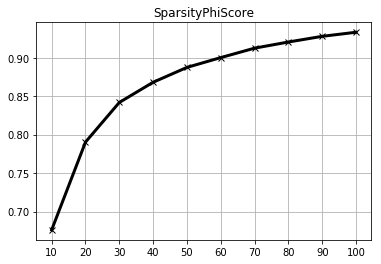

In [17]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [18]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()

In [19]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

Text(0.5, 1.0, 'SparsityThetaScore')

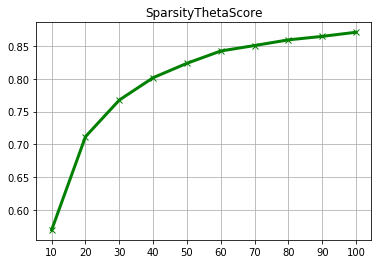

In [20]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [21]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()

In [22]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

Text(0.5, 1.0, 'PerplexityScore')

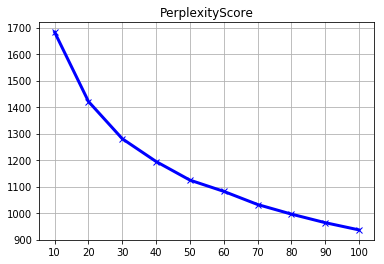

In [23]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

Text(0.5, 1.0, 'CoherenceScore')

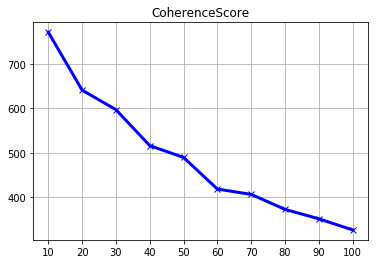

In [24]:
plt.plot(step, coherences, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('CoherenceScore')

In [25]:
best_model = model_list[-1]

In [26]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")

topic_0: ['госдума' 'депутат' 'законопроект' 'закон' 'поправка' 'внести' 'комитет'
 'инициатива' 'чтение' 'предложить']
topic_1: ['фонд' 'подпись' 'матвиенко' 'сбор' 'доход' 'собрать' 'валентин'
 'собирать' 'лист' 'декларация']
topic_2: ['письмо' 'телефон' 'обращение' 'просьба' 'доклад' 'мобильный' 'связь'
 'башкирия' 'обратиться' 'голодовка']
topic_3: ['развитие' 'институт' 'проект' 'программа' 'центр' 'создание' 'академия'
 'наука' 'научный' 'культура']
topic_4: ['документ' 'организация' 'деятельность' 'должный' 'закон' 'федеральный'
 'согласно' 'информация' 'министерство' 'подписать']
topic_5: ['флот' 'корабль' 'морской' 'лодка' 'вмф' 'адмирал' 'подводный' 'северный'
 'черноморский' 'мор']
topic_6: ['ущерб' 'фирма' 'мошенничество' 'васильев' 'хищение' 'деньга' 'имущество'
 'продать' 'следствие' 'сумма']
topic_7: ['россиянин' 'опрос' 'опросить' 'мнение' 'считать' 'рейтинг' 'респондент'
 'центр' 'страна' 'исследование']
topic_8: ['губернатор' 'регион' 'округа' 'областной' 'автономный'

topic_96: ['путин' 'государство' 'сказать' 'страна' 'вопрос' 'наш' 'подчеркнуть'
 'должный' 'очень' 'встреча']
topic_97: ['задержать' 'полиция' 'полицейский' 'мвд' 'задержание' 'гу' 'отпустить'
 'доставить' 'овд' 'пресс']
topic_98: ['летний' 'мужчина' 'женщина' 'девушка' 'смерть' 'тело' 'житель'
 'обнаружить' 'сообщаться' 'сайт']
topic_99: ['военный' 'оборона' 'армия' 'войско' 'генерал' 'сила' 'минобороны'
 'вооружённый' 'министр' 'военнослужащий']


shape theta: (100, 127558)


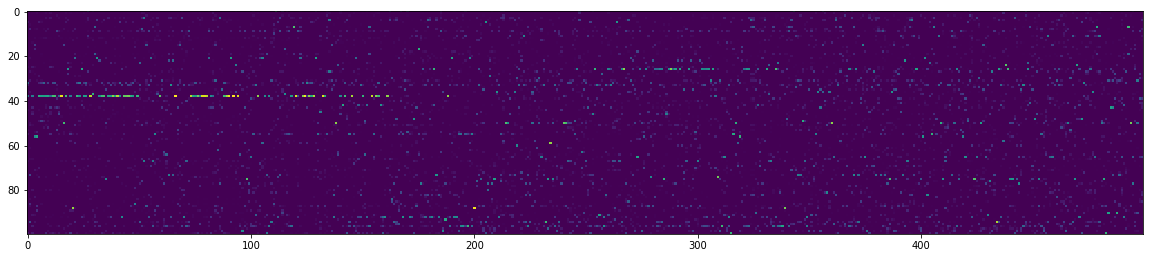

In [27]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vec, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

In [28]:
theta = best_model.transform(batch_vectorizer=batch_vec)
theta = theta.T
theta.head()

topic_0  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  \
106000  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
106001  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
106002  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
106003  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
106004  0.056796      0.0      0.0      0.0      0.0      0.0      0.0   

        topic_7  topic_8   topic_9  ...  topic_90  topic_91  topic_92  \
106000      0.0      0.0  0.000000  ...       0.0  0.000000       0.0   
106001      0.0      0.0  0.000000  ...       0.0  0.000000       0.0   
106002      0.0      0.0  0.000000  ...       0.0  0.037126       0.0   
106003      0.0      0.0  0.006004  ...       0.0  0.030106       0.0   
106004      0.0      0.0  0.066202  ...       0.0  0.032641       0.0   

        topic_93  topic_94  topic_95  topic_96  topic_97  topic_98  topic_99  
106000       0.0       0.0       0.0  0.000000  0.000000  0.000000       0.0  
106001       0.0       0.0       0.0  0.058376  0.090986  0.039122       0.0  
106002       0.0       0.0       0.0  0.000000  0.000000  0.000000       0.0  
106003       0.0       0.0       0.0  0.000000  0.000000  0.000000       0.0  
106004       0.0       0.0       0.0  0.239502  0.000000  0.000000       0.0  

[5 rows x 100 columns]